In [1]:
!pip3 install fasttext
!pip3 install pandoc

In [2]:
import json
import logging
import pickle

import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve

from fasttext_loader import FasttextLoader
from preprocessing_tools import inds_texts_labels, MultiLabelEncoder, MultilabelStratifiedKFold
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
#проверка, что используется gpu
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10200299138287157740
]


In [4]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [5]:
%config InlineBackend.figure_format='retina'

In [6]:
seed = 7
np.random.seed(seed)

## Data loading

In [7]:
with open('nations.json', 'r') as fp:
    label_to_nation = json.load(fp)
label_to_nation = {int(k): v for k, v in label_to_nation.items()}
#label_to_nation[mlb.le.inverse_transform(j)]

In [8]:
w2v = FasttextLoader()
w2v.load("/Users/Ruslan/Desktop/xeno-stuff/fasttext/fasttext.bin")

In [9]:
X, _, y = inds_texts_labels("../data/all_xeno_labeled.json", w2v)
w2v_weigths = w2v.weights()
mlb = MultiLabelEncoder()
y = mlb.fit_transform(y)

Num of data < min_len: 0
Num of multilabel data: 457
Num of not_xeno or unknown: 368
Num of duplicates: 0


In [10]:
max_length = max([len(elem) for elem in X])
X = sequence.pad_sequences(X, maxlen=max_length)
print("X.shape {}".format(X.shape))

X.shape (3113, 446)


In [11]:
target_shape = y.shape[1]
target_shape

7

## Prerequisites

In [12]:
#initial
rnn_params = {"dropout": 0.5, "optimizer": "Adagrad", "epochs": 21, "batch_size": 8}

In [13]:
def rnn_model(dropout=rnn_params["dropout"], optimizer=rnn_params["optimizer"]):
    print('building network')
    global w2v, max_length, target_shape, w2v_weigths
    model = Sequential()
    model.add(Embedding(w2v.vocabulary_size() + 1, w2v.vector_dim(), input_length=max_length,
                        weights=[w2v_weigths], trainable=False))
    model.add(GRU(w2v.vector_dim()))
    model.add(Dropout(dropout))
    model.add(Dense(target_shape, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [14]:
def f1_scorer(estimator, X, y):
    preds = estimator.predict_proba(X)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    return f1_score(y, preds, average="samples")

In [15]:
cv = MultilabelStratifiedKFold(targets=y, n_folds=3)

## Learning Curves

In [16]:
def build_learning_curve_data(estimator, X, y, scorer, cv=None, n_jobs=1,
                              train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring=scorer, cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes, verbose=True)
    return train_sizes, train_scores, test_scores

In [17]:
def plot_learning_curve(learning_curve_data, title, score, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(score)
    train_sizes, train_scores, test_scores = learning_curve_data
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [18]:
title = "Learning Curves (Recurrent Neural Network)"
estimator = KerasClassifier(build_fn=rnn_model,
                            epochs=rnn_params["epochs"],
                            batch_size=rnn_params["batch_size"],
                            verbose=True)
path = "fasttext_{}"

estimating f1
Fold distributions are
[[ 180.   27.  150.  571.  174.   94.   62.]
 [ 170.   26.  141.  538.  164.   88.   59.]
 [ 168.   25.  139.  531.  162.   87.   58.]]
[learning_curve] Training set sizes: [ 203  662 1120 1578 2037]
building network
Epoch 1/21
203/203 [==============================] - 11s 53ms/step - loss: 0.4560 - acc: 0.8037
Epoch 2/21
203/203 [==============================] - 15s 74ms/step - loss: 0.3446 - acc: 0.8557
Epoch 3/21
203/203 [==============================] - 15s 76ms/step - loss: 0.2753 - acc: 0.8944
Epoch 4/21
203/203 [==============================] - 14s 71ms/step - loss: 0.2267 - acc: 0.9156
Epoch 5/21
203/203 [==============================] - 16s 80ms/step - loss: 0.2087 - acc: 0.9170
Epoch 6/21
203/203 [==============================] - 16s 78ms/step - loss: 0.1718 - acc: 0.9282
Epoch 7/21
203/203 [==============================] - 18s 87ms/step - loss: 0.1517 - acc: 0.9514
Epoch 8/21
203/203 [==============================] - 14s 67ms/step

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


203/203 [==============================] - 4s 20ms/step
building network
Epoch 1/21
662/662 [==============================] - 53s 79ms/step - loss: 0.3703 - acc: 0.8496
Epoch 2/21
662/662 [==============================] - 41s 62ms/step - loss: 0.2247 - acc: 0.9154
Epoch 3/21
662/662 [==============================] - 41s 62ms/step - loss: 0.1666 - acc: 0.9385
Epoch 4/21
662/662 [==============================] - 36s 55ms/step - loss: 0.1328 - acc: 0.9525
Epoch 5/21
662/662 [==============================] - 40s 60ms/step - loss: 0.1125 - acc: 0.9631
Epoch 6/21
662/662 [==============================] - 43s 65ms/step - loss: 0.0881 - acc: 0.9735
Epoch 7/21
662/662 [==============================] - 42s 63ms/step - loss: 0.0823 - acc: 0.9748
Epoch 8/21
662/662 [==============================] - 39s 59ms/step - loss: 0.0679 - acc: 0.9808
Epoch 9/21
662/662 [==============================] - 46s 70ms/step - loss: 0.0558 - acc: 0.9864
Epoch 10/21
662/662 [==============================] -

1578/1578 [==============================] - 101s 64ms/step - loss: 0.0730 - acc: 0.9784
Epoch 9/21
1578/1578 [==============================] - 111s 70ms/step - loss: 0.0660 - acc: 0.9785
Epoch 10/21
1578/1578 [==============================] - 106s 67ms/step - loss: 0.0604 - acc: 0.9813
Epoch 11/21
1578/1578 [==============================] - 112s 71ms/step - loss: 0.0545 - acc: 0.9841
Epoch 12/21
1578/1578 [==============================] - 104s 66ms/step - loss: 0.0513 - acc: 0.9838
Epoch 13/21
1578/1578 [==============================] - 130s 82ms/step - loss: 0.0464 - acc: 0.9860
Epoch 14/21
1578/1578 [==============================] - 107s 68ms/step - loss: 0.0425 - acc: 0.9886
Epoch 15/21
1578/1578 [==============================] - 114s 72ms/step - loss: 0.0378 - acc: 0.9909
Epoch 16/21
1578/1578 [==============================] - 117s 74ms/step - loss: 0.0341 - acc: 0.9913
Epoch 17/21
1578/1578 [==============================] - 105s 67ms/step - loss: 0.0373 - acc: 0.9901
Epo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 418.9min finished


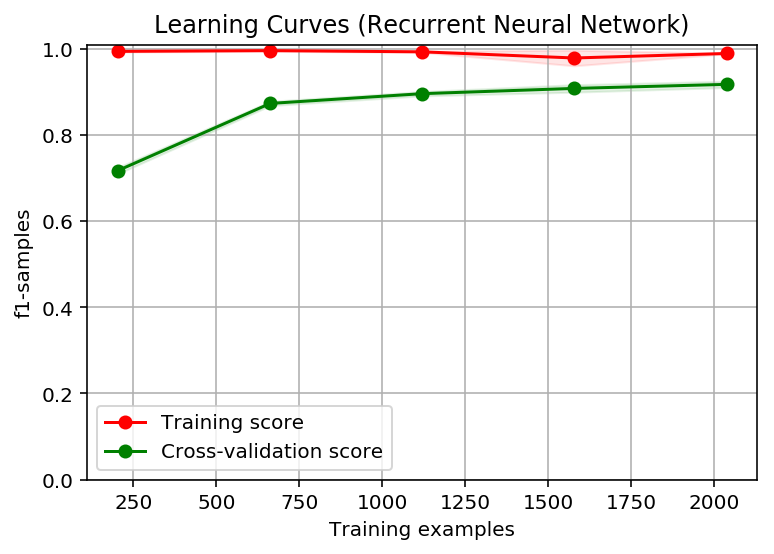

In [19]:
print("estimating f1")
path_f1 = path.format("f1.pkl")
train_sizes, train_scores, test_scores = build_learning_curve_data(estimator, X, y, scorer=f1_scorer, cv=cv)
with open(path_f1, "wb") as learning_curve_data_file:
    pickle.dump((train_sizes, train_scores, test_scores), learning_curve_data_file)
with open(path_f1, "rb") as learning_curve_data_file:
    train_sizes, train_scores, test_scores = pickle.load(learning_curve_data_file)
plot_learning_curve((train_sizes, train_scores, test_scores), title, "f1-samples",
                    ylim=(0.0, 1.01))
plt.savefig(path.format("f1.png"), dpi=900)
plt.show()